In [12]:
from pyspark.sql import SparkSession
import json
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd



Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["yelp"]

# Drop old collections if they exist
db["business"].drop()
db["review"].drop()

# === Trim and load only first 100000 businesses ===
with open("data/yelp_academic_dataset_business.json", "r", encoding="utf-8") as f:
    business_data = [json.loads(line) for _, line in zip(range(100000), f)]
db["business"].insert_many(business_data)
print(f"{len(business_data)} businesses")

# === Trim and load only first 20000 reviews ===
with open("data/yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(20000), f)]
db["review"].insert_many(review_data)
print(f"{len(review_data)} reviews")

✅ Inserted 100000 businesses
✅ Inserted 20000 reviews


In [36]:

spark = SparkSession.builder.appName("YelpProject").getOrCreate()

In [37]:
# Read documents, exclude '_id'
business_docs = list(db["business"].find({}, {"_id": 0}))
review_docs = list(db["review"].find({}, {"_id": 0}))

# Convert to Spark DataFrames
df_business = spark.createDataFrame(business_docs)
df_review = spark.createDataFrame(review_docs)

df_business.show(3)
df_review.show(3)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{ByAppointmentOnl...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{BusinessAcceptsC...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{Thursday -> 8:0-...|      1| 38.551126|  -90.335695|    

In [38]:
#top businesses with highest review counts
top_business=df_business.orderBy("review_count", ascending=False).limit(20)
top_business.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      112 19th Ave S|{BikeParking -> T...|GXFMD0Z4jEVZBCsbP...|American (Traditi...|    Nashville|{Thursday -> 11:0...|      1|36.1513871523|-86.7966029393|Hattie B’s Hot Ch...|      37203|        6093|  4.5|   TN|
|        441 Royal St|{BikeParking -> T...|VQcCL9PiNL_wkGf-u...|American (New), R...|  New Orleans|{Thursday -> 11:0...|      1|  29.956

In [ ]:
from pyspark.sql.functions import avg

#average star rating per city 
avg_rating_per_city = df_business.groupBy("city").agg(avg("stars").alias("avg_rating"))
avg_rating_per_city.show()

#supposed to write a new table for this, but didn't work that well
avg_rating_from_cities = avg_rating_per_city.toPandas().to_dict("records")
db["avg_rating_cites"].drop()
db["avg_rating_cities"].insert_many(avg_rating_from_cities)

+-------------------+------------------+
|               city|        avg_rating|
+-------------------+------------------+
|       Harleysville| 3.314516129032258|
|         Westampton|2.9814814814814814|
|        Merion Park|               3.5|
|              Bucks| 4.071428571428571|
|          Worcester|3.5714285714285716|
|        Springfield|3.1224066390041494|
|      Pleasant View|3.0172413793103448|
|            Truckee|               4.7|
|          Frontenac| 3.230769230769231|
|        Marcus Hook|3.6944444444444446|
|    King Of Prussia| 3.066666666666667|
|     Lafayette Hill| 3.842857142857143|
| Indian Rocks Beach|3.8796296296296298|
|      Lawrenceville|              3.25|
|        Cherry Hill|3.4042721518987342|
|         Plainfield|3.3940217391304346|
|           Olivette|3.6136363636363638|
|          Levittown|              3.33|
|         Terra Ceia|               4.0|
|Pittsgrove Township|               4.0|
+-------------------+------------------+
only showing top

InsertManyResult([ObjectId('67f7f10c5663dcbf293e05ff'), ObjectId('67f7f10c5663dcbf293e0600'), ObjectId('67f7f10c5663dcbf293e0601'), ObjectId('67f7f10c5663dcbf293e0602'), ObjectId('67f7f10c5663dcbf293e0603'), ObjectId('67f7f10c5663dcbf293e0604'), ObjectId('67f7f10c5663dcbf293e0605'), ObjectId('67f7f10c5663dcbf293e0606'), ObjectId('67f7f10c5663dcbf293e0607'), ObjectId('67f7f10c5663dcbf293e0608'), ObjectId('67f7f10c5663dcbf293e0609'), ObjectId('67f7f10c5663dcbf293e060a'), ObjectId('67f7f10c5663dcbf293e060b'), ObjectId('67f7f10c5663dcbf293e060c'), ObjectId('67f7f10c5663dcbf293e060d'), ObjectId('67f7f10c5663dcbf293e060e'), ObjectId('67f7f10c5663dcbf293e060f'), ObjectId('67f7f10c5663dcbf293e0610'), ObjectId('67f7f10c5663dcbf293e0611'), ObjectId('67f7f10c5663dcbf293e0612'), ObjectId('67f7f10c5663dcbf293e0613'), ObjectId('67f7f10c5663dcbf293e0614'), ObjectId('67f7f10c5663dcbf293e0615'), ObjectId('67f7f10c5663dcbf293e0616'), ObjectId('67f7f10c5663dcbf293e0617'), ObjectId('67f7f10c5663dcbf293e06

In [72]:
pipeline = [
    {"$group": {"_id": "$city", "avg_rating": {"$avg": "$stars"}}},
    {"$sort": {"avg_rating": -1}},
    {"$limit": 30}
]
top_cities = list(db.business.aggregate(pipeline))
top_cities

[{'_id': 'LOWER PROVIDENCE', 'avg_rating': 5.0},
 {'_id': 'Palm harbor', 'avg_rating': 5.0},
 {'_id': 'Lenni', 'avg_rating': 5.0},
 {'_id': 'Creve Couer', 'avg_rating': 5.0},
 {'_id': 'Center City Philadelphia', 'avg_rating': 5.0},
 {'_id': 'Covington', 'avg_rating': 5.0},
 {'_id': 'Secane ', 'avg_rating': 5.0},
 {'_id': 'TARPON SPRINGS', 'avg_rating': 5.0},
 {'_id': 'Picture Rocks', 'avg_rating': 5.0},
 {'_id': 'Norriton', 'avg_rating': 5.0},
 {'_id': 'Monrovia', 'avg_rating': 5.0},
 {'_id': 'South Lake Tahoe', 'avg_rating': 5.0},
 {'_id': 'Wilmington Manor', 'avg_rating': 5.0},
 {'_id': 'Santa Barbara,', 'avg_rating': 5.0},
 {'_id': 'Los Angeles', 'avg_rating': 5.0},
 {'_id': 'King of Prussi', 'avg_rating': 5.0},
 {'_id': 'Parker Ford', 'avg_rating': 5.0},
 {'_id': 'Kings Beach', 'avg_rating': 5.0},
 {'_id': 'SPARKS', 'avg_rating': 5.0},
 {'_id': 'Arizona', 'avg_rating': 5.0},
 {'_id': 'Ellisville', 'avg_rating': 5.0},
 {'_id': 'Grenloch', 'avg_rating': 5.0},
 {'_id': 'Bradenton', 'a

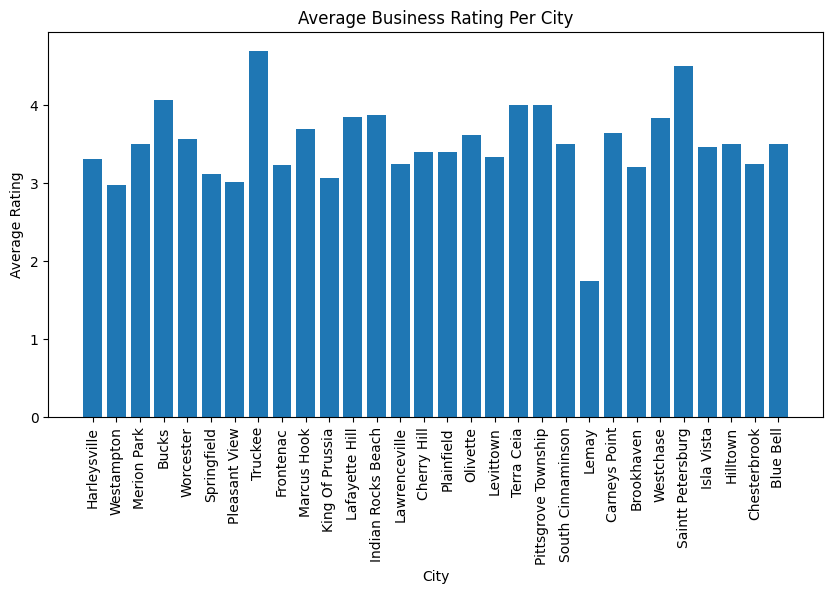

In [ ]:
#overall average rating per city
pandas_df = avg_rating_per_city.toPandas()
top_30_cities = pandas_df.head(30)
plt.figure(figsize=(10,5))
plt.bar(top_30_cities["city"], top_30_cities["avg_rating"])
plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Average Rating")
plt.title("Average Business Rating Per City")
plt.show()

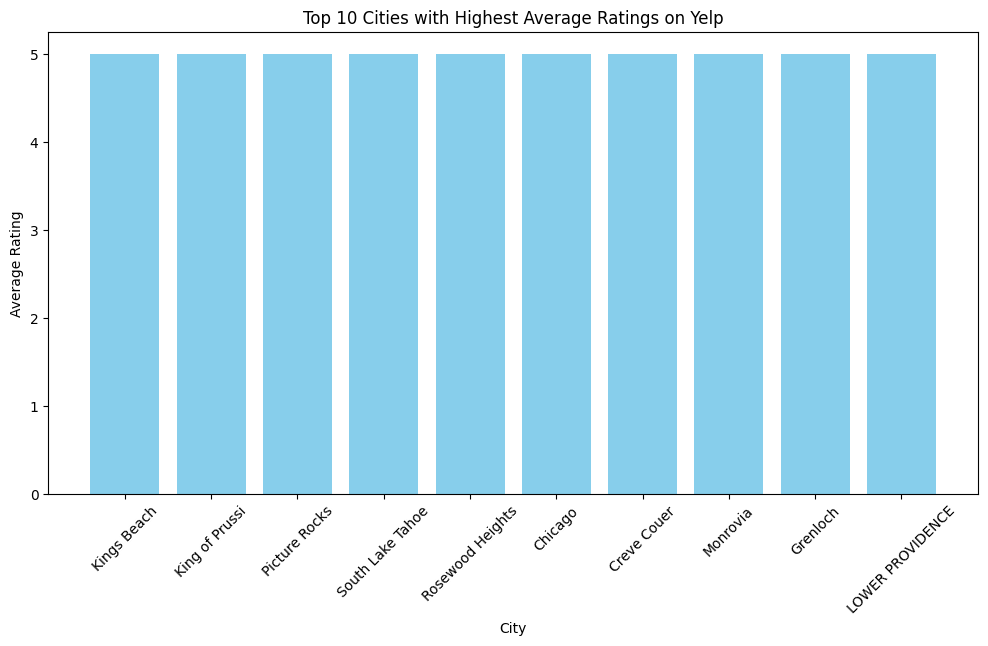

In [59]:
#top 30 cities

# Convert MongoDB result to DataFrame
df_top_cities = pd.DataFrame(top_cities)

# Rename columns for clarity
df_top_cities.rename(columns={"_id": "City", "avg_rating": "Average Rating"}, inplace=True)

df_top_cities = df_top_cities.sort_values(by="Average Rating", ascending=False)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_top_cities["City"], df_top_cities["Average Rating"], color="skyblue")

# Labels and Title
plt.xlabel("City")
plt.ylabel("Average Rating")
plt.title("Top 10 Cities with Highest Average Ratings on Yelp")
plt.xticks(rotation=45)  # Rotate city names for better readability

# Show plot
plt.show()


In [43]:
from pyspark.sql.functions import explode, split


category_counts = df_business.withColumn("category", explode(split(df_business["categories"], ", "))) \
                             .groupBy("category").count() \
                             .orderBy("count", ascending=False)

category_counts.show(10) 

+----------------+-----+
|        category|count|
+----------------+-----+
|     Restaurants|34749|
|            Food|18517|
|        Shopping|16277|
|   Home Services| 9622|
|   Beauty & Spas| 9504|
|       Nightlife| 8124|
|Health & Medical| 7835|
|  Local Services| 7470|
|            Bars| 7327|
|      Automotive| 7131|
+----------------+-----+
only showing top 10 rows



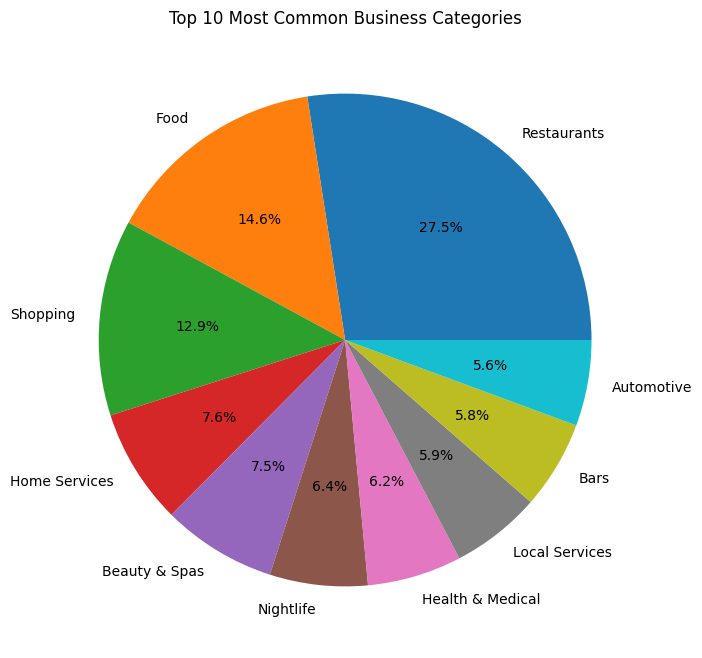

In [94]:
top_categories = category_counts.toPandas().head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_categories["count"], labels=top_categories["category"], autopct="%1.1f%%")
plt.title("Top 10 Most Common Business Categories")
plt.show()

In [45]:
df_business.createOrReplaceTempView("business")
spark.sql("SELECT city, AVG(stars) FROM business GROUP BY city ORDER BY AVG(stars) DESC LIMIT 10").show()

+-------------+----------+
|         city|avg(stars)|
+-------------+----------+
|      Secane |       5.0|
|Pass-a-Grille|       5.0|
|     Norriton|       5.0|
|      Fernley|       5.0|
| phoenixville|       5.0|
| Webster Grvs|       5.0|
|Birchrunville|       5.0|
|       SPARKS|       5.0|
|        Reno |       5.0|
|      Arizona|       5.0|
+-------------+----------+



In [62]:
from pyspark.sql.functions import col, expr

# Add a weighted score: Higher stars + more reviews = better ranking
df_best_restaurants = df_business.filter(df_business["categories"].rlike("(?i)Restaurant")) \
                                .filter(df_business["review_count"] > 400) \
                                .withColumn("weighted_score", expr("stars * log(review_count)")) \
                                .orderBy(col("weighted_score").desc()) \
                                .limit(30)  

df_best_restaurants.show()


+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+------------------+
|             address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|    weighted_score|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+------------------+
|      112 19th Ave S|{BikeParking -> T...|GXFMD0Z4jEVZBCsbP...|American (Traditi...|   Nashville|{Thursday -> 11:0...|      1|36.1513871523|-86.7966029393|Hattie B’s Hot Ch...|      37203|        6093|  4.5|   TN|39.217031326118224|
| 1403 Washington Ave|{BikeParking -> T...|_C7QiQQc47AOEv4PE...|

In [65]:
best_restaurants= df_best_restaurants.toPandas().to_dict("records")
db["best_restaurants"].drop()
db["best_restaurants"].insert_many(best_restaurants)

InsertManyResult([ObjectId('67f7eb0d5663dcbf293e05e1'), ObjectId('67f7eb0d5663dcbf293e05e2'), ObjectId('67f7eb0d5663dcbf293e05e3'), ObjectId('67f7eb0d5663dcbf293e05e4'), ObjectId('67f7eb0d5663dcbf293e05e5'), ObjectId('67f7eb0d5663dcbf293e05e6'), ObjectId('67f7eb0d5663dcbf293e05e7'), ObjectId('67f7eb0d5663dcbf293e05e8'), ObjectId('67f7eb0d5663dcbf293e05e9'), ObjectId('67f7eb0d5663dcbf293e05ea'), ObjectId('67f7eb0d5663dcbf293e05eb'), ObjectId('67f7eb0d5663dcbf293e05ec'), ObjectId('67f7eb0d5663dcbf293e05ed'), ObjectId('67f7eb0d5663dcbf293e05ee'), ObjectId('67f7eb0d5663dcbf293e05ef'), ObjectId('67f7eb0d5663dcbf293e05f0'), ObjectId('67f7eb0d5663dcbf293e05f1'), ObjectId('67f7eb0d5663dcbf293e05f2'), ObjectId('67f7eb0d5663dcbf293e05f3'), ObjectId('67f7eb0d5663dcbf293e05f4'), ObjectId('67f7eb0d5663dcbf293e05f5'), ObjectId('67f7eb0d5663dcbf293e05f6'), ObjectId('67f7eb0d5663dcbf293e05f7'), ObjectId('67f7eb0d5663dcbf293e05f8'), ObjectId('67f7eb0d5663dcbf293e05f9'), ObjectId('67f7eb0d5663dcbf293e05

In [ ]:
#nevermind  
best_restaurants_docs = list(db["best_restaurants"].find({}, {"_id": 0}))
best_restaurants_df = spark.createDataFrame(best_restaurants_docs)


+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+------------------+
|             address|          attributes|         business_id|          categories|       city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|    weighted_score|
+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+------------------+
|      112 19th Ave S|{BikeParking -> T...|GXFMD0Z4jEVZBCsbP...|American (Traditi...|  Nashville|{Monday -> 0:0-0:...|      1|36.1513871523|-86.7966029393|Hattie B’s Hot Ch...|      37203|        6093|  4.5|   TN|39.217031326118224|
| 1403 Washington Ave|{BikeParking -> T...|_C7QiQQc47AOEv4PE...|Fren

In [ ]:

state_counts = df_business.withColumn("state", explode(split(df_business["state"], ", "))) \
                             .groupBy("state").count() \
                             .orderBy("count", ascending=False)
state_counts.show(20)

+-----+-----+
|state|count|
+-----+-----+
|   PA|22555|
|   FL|17529|
|   TN| 7994|
|   IN| 7464|
|   MO| 7314|
|   LA| 6632|
|   AZ| 6602|
|   NJ| 5691|
|   NV| 5164|
|   AB| 3702|
|   CA| 3428|
|   ID| 2990|
|   DE| 1475|
|   IL| 1443|
|   TX|    4|
|   CO|    3|
|   WA|    2|
|   HI|    2|
|   NC|    1|
|   MT|    1|
+-----+-----+
only showing top 20 rows



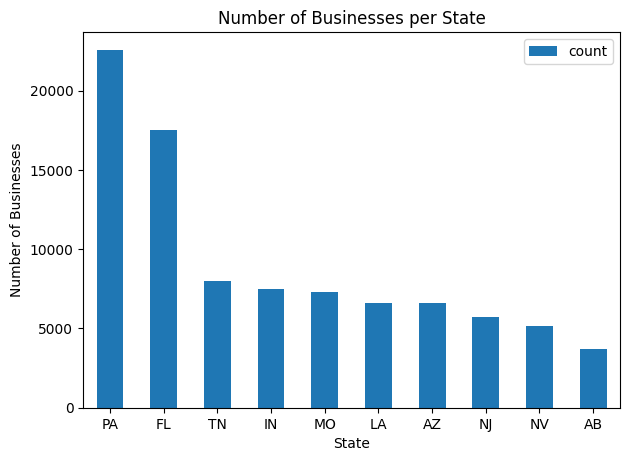

In [91]:
number_of_businesses_per_state = state_counts.toPandas().head(10)
number_of_businesses_per_state.plot(
    kind='bar',
    x='state',
    y='count',  # replace 'count' with your actual column for number of businesses
    title='Number of Businesses per State'
)
plt.xlabel("State")

plt.ylabel("Number of Businesses")
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

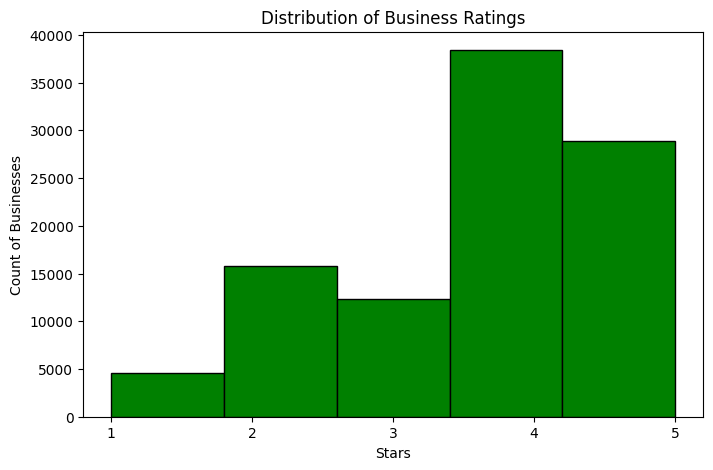

In [95]:
ratings = df_business.select("stars").toPandas()

plt.figure(figsize=(8,5))
plt.hist(ratings["stars"], bins=5, edgecolor='black', color='green')
plt.xlabel("Stars")
plt.ylabel("Count of Businesses")
plt.title("Distribution of Business Ratings")
plt.xticks([1,2,3,4,5])
plt.show()